In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
import gym
import time 
%matplotlib inline

# ---------------------------------------------------------------------------------------------------------------
# NLP - Neural Networks------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

In [2]:
### TIPS:

# Remember to flatten after max_pooling! Then in the output the layers fed to the following 
# dense layer are listed as follows: flatten (Flatten) (None,250), so it would be 250!


### Convolutional Neural Networks

In [3]:
# An epoch consists of one full cycle through the training data. This is usually many steps. 
# If you have 2,000 images and use a batch size of 10 then 2,000/10 = 200 steps per epoch.
# Keep in mind that if you have a validation set of say 0.2, then ((0.8*2000)/10)* # of epochs = Total training steps.

In [4]:
mnist = tf.keras.datasets.mnist
#### x_train -> 60,000 images 28x28
#### y_train -> 0-9
#### x_test -> 10,000 images 28x28
#### y_test -> 0-9 corresponding
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# Normalize to make numbers 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0
ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
ndata_train

60000

In [7]:
ndata_test

10000

In [8]:
## Reshaping for convolutional NN
## number of images, rows, columns, color code
x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))
xshape = x_train.shape[1:4]

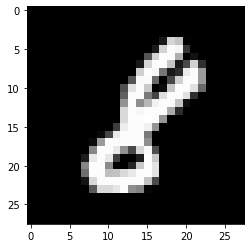

In [9]:
plt.imshow(x_train[10001,:,:], cmap = 'gray');

In [10]:
NNmodel = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=50, kernel_size=(2,2), activation=tf.nn.relu, input_shape=xshape),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides=2),
        tf.keras.layers.Conv2D(filters=25, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(300, activation=tf.nn.elu, kernel_regularizer = tf.keras.regularizers.l1(0.0000005)),
        tf.keras.layers.Dropout(0.08),
        tf.keras.layers.Dense(150, activation=tf.nn.elu),
        tf.keras.layers.Dropout(0.04),
        tf.keras.layers.Dense(75, activation=tf.nn.elu),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(10,activation=tf.nn.softmax)
        ])

In [11]:
NNmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 50)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 25)        11275     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 25)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 625)               0         
                                                                 
 dense (Dense)               (None, 300)               1

In [12]:
#Train with validation set
NNmodel.fit(x_train,y_train,epochs=1,validation_split=0.2,batch_size=100)

480/480 [==============================] - 11s 23ms/step - loss: 0.2110 - accuracy: 0.9366 - val_loss: 0.0788 - val_accuracy: 0.9772


In [13]:
#Now train on entire training set
NNmodel.fit(x_train,y_train,epochs=2,batch_size=100)

Epoch 1/2
600/600 [==============================] - 13s 21ms/step - loss: 0.0709 - accuracy: 0.9790
Epoch 2/2
600/600 [==============================] - 13s 21ms/step - loss: 0.0522 - accuracy: 0.9852


In [14]:
print('This model predicts '+str(NNmodel.evaluate(x_test,y_test)[1]*100) +'% of the test data correctly')

313/313 [==============================] - 1s 3ms/step - loss: 0.0592 - accuracy: 0.9810
This model predicts 98.1000006198883% of the test data correctly


In [15]:
pred_probs = NNmodel.predict(x_test)
pred2 = np.argmax(pred_probs, axis=1)
print(np.mean(pred2 == y_test))

0.981


In [16]:
df  = pd.DataFrame(index=[x for x in range(len(x_test)) ], columns = ['actual','predicted']).fillna(0)
for i in range(len(x_test)):
    df.loc[i,'actual'] = y_test[i]
    df.loc[i,'predicted'] = np.argmax(pred_probs[i])

In [17]:
df.head()

,actual,predicted
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [18]:
df[df.actual != df.predicted]['actual'].value_counts().sort_values(ascending = False)

2    34
5    34
4    30
8    30
7    23
9    17
6    12
0     7
3     3
Name: actual, dtype: int64

In [19]:
## We see below the (# of number) that were misclassified as a different number:
j = 0
for i in range(len(df)):
    if (df.actual[i] == 6) & (df.predicted[i] != 6):
        j += 1
        print("Misclassification #", j)
        print("An image of a number 6 was incorrectly classified as the number", df.predicted[i])
        print(i, "\n")
    i += 1

Misclassification # 1
An image of a number 6 was incorrectly classified as the number 5
1014 

Misclassification # 2
An image of a number 6 was incorrectly classified as the number 1
2135 

Misclassification # 3
An image of a number 6 was incorrectly classified as the number 5
2454 

Misclassification # 4
An image of a number 6 was incorrectly classified as the number 1
2654 

Misclassification # 5
An image of a number 6 was incorrectly classified as the number 0
3422 

Misclassification # 6
An image of a number 6 was incorrectly classified as the number 4
3520 

Misclassification # 7
An image of a number 6 was incorrectly classified as the number 5
3550 

Misclassification # 8
An image of a number 6 was incorrectly classified as the number 8
3762 

Misclassification # 9
An image of a number 6 was incorrectly classified as the number 5
4536 

Misclassification # 10
An image of a number 6 was incorrectly classified as the number 8
4571 

Misclassification # 11
An image of a number 6 was

-----This was incorrectly classified as the number 5
AxesImage(54,36;334.8x217.44)


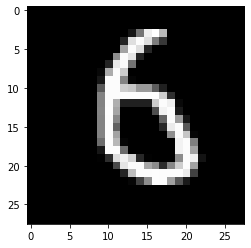



-----This was incorrectly classified as the number 5
AxesImage(54,36;334.8x217.44)


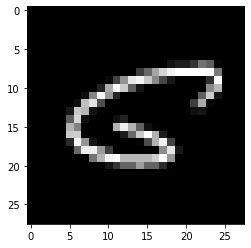



-----This was incorrectly classified as the number 5
AxesImage(54,36;334.8x217.44)


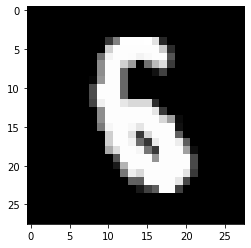

In [20]:
## Now let's take a look at a few of the images of (number) that were misclassified:
mylist1 = [786, 1014, 1182]
mylist11 = [5,5,5]
for i in range(3):
    print("-----This was incorrectly classified as the number", mylist11[i])
    print(plt.imshow(x_test[mylist1[i],:,:], cmap = 'gray'))
    plt.pause(0.0001)
    print("\n")

### Optimization Algorithms

#### GRADIENT DESCENT - optimization algorithm for finding a local minimum of a differentiable function. Gradient descent is simply used to find the values of a function's parameters (coefficients) that minimize a cost function as far as possible.

#### SGD - algorithm derivative is computed taking one point at a time.

#### ADAM - Adaptive Moment Estimation, combination of RMSprop and Stochastic Gradient Descent with momentum. Adam computes adaptive learning rates for each parameter

#### RMSprop - divides the learning rate by an exponentially decaying average of squared gradients.

# ---------------------------------------------------------------------------------------------------------------
# Simulation-----------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

### Tossing coins a bunch of times

In [21]:
HT = np.random.choice(['Heads','Tails'],15,p=[0.5,0.5])
HT

array(['Tails', 'Tails', 'Tails', 'Heads', 'Tails', 'Heads', 'Heads',
       'Tails', 'Tails', 'Heads', 'Tails', 'Heads', 'Tails', 'Heads',
       'Tails'], dtype='<U5')

In [22]:
HT = np.random.choice(['Heads','Tails'],15,p=[0.5,0.5])
HT

array(['Heads', 'Tails', 'Heads', 'Tails', 'Heads', 'Tails', 'Tails',
       'Tails', 'Tails', 'Tails', 'Tails', 'Heads', 'Heads', 'Heads',
       'Tails'], dtype='<U5')

In [23]:
found_streak=False
for start in range(12):
    segment = HT[start:(start+4)]
    print(segment)
    if np.sum(segment=='Heads')==4:
        found_streak = True
    
found_streak

['Heads' 'Tails' 'Heads' 'Tails']
['Tails' 'Heads' 'Tails' 'Heads']
['Heads' 'Tails' 'Heads' 'Tails']
['Tails' 'Heads' 'Tails' 'Tails']
['Heads' 'Tails' 'Tails' 'Tails']
['Tails' 'Tails' 'Tails' 'Tails']
['Tails' 'Tails' 'Tails' 'Tails']
['Tails' 'Tails' 'Tails' 'Tails']
['Tails' 'Tails' 'Tails' 'Heads']
['Tails' 'Tails' 'Heads' 'Heads']
['Tails' 'Heads' 'Heads' 'Heads']
['Heads' 'Heads' 'Heads' 'Tails']


False

In [25]:
nsim = 100000
streak4 = np.array([False]*nsim)
for flip in range(nsim):
    HT = np.random.choice(['Heads','Tails'],15,p=[0.5,0.5])
    for start in range(12):
        segment = HT[start:(start+4)]
        if np.sum(segment=='Heads')==4:
            streak4[flip] = True
            
np.mean(streak4)

0.37294

In [26]:
nsim = 100000
finalTotal = []
for roll in range(nsim):
    total = []
    x = 1
    while x == 1:
        if np.sum(total) > 3:
            if np.sum(total) > 7:
                total = 0
            finalTotal.append(np.sum(total))
            x = 0;
        elif np.sum(total) < 4:
            diceRoll = (np.random.choice(range(1,7)))
            total.append(diceRoll)    
    finalTotal.append(np.sum(total))           
print("Your average score is",np.mean(finalTotal))

Your average score is 4.66357


### Saving for retirement

In [27]:
tvec = np.arange(35)
value = 2000000
value_vec = np.zeros(35)
for year in range(35):
    port_return = np.random.normal(size = 1, loc = 0.07, scale = 0.1)
    value = value*(1+port_return)
    value = value - 150000
    if (value <= 0):
        value = 0
    value_vec[year] = value

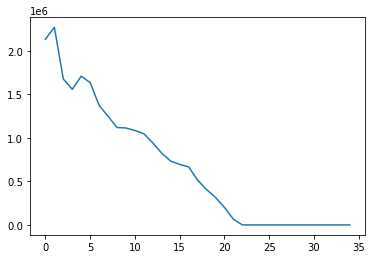

In [28]:
plt.plot(tvec,value_vec);

In [29]:
nsim = 10000
def_vec_rd = np.array([False]*nsim)
port_val_vec_rd = np.zeros(nsim)
for sim in range(nsim):
    value = 2000000
    death = np.random.choice(range(25,36))
    for year in range(death):
        port_return = np.random.normal(size = 1, loc = 0.07, scale = 0.1)
        value = value*(1+port_return)
        value = value - 150000
        if (value <= 0):
            value = 0
    if value <= 0:
        def_vec_rd[sim] = True
    port_val_vec_rd[sim] = value

In [30]:
np.mean(def_vec_rd)

0.4655

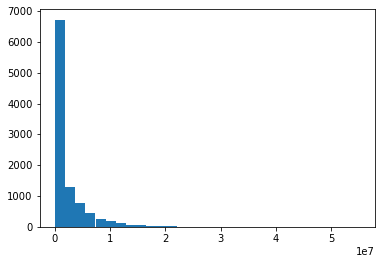

In [31]:
plt.hist(port_val_vec_rd,bins=30);

### Calculate means,variances, etc of output

In [32]:
##### Examples Above #####

# ---------------------------------------------------------------------------------------------------------------
# Stochastic Programming---------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

In [33]:
### TIPS:

# Linear, integer, non-linear, stochastic optimization all involve decisions at a single time

### Expectations

## $ 𝐸_Y [𝑓(𝑌)]  ≠  𝑓(𝐸[𝑌])\  !!!!!! $

### Sample Average Approximation (SAA)

## $$ \max_{x} \frac{1}{n} \sum^n_{i=1} f(x,Y_i) $$

#### The newsvendor problem is an example of SAA.    
#### SAA is biased! SAA typically overestimates how well you can do! ####

### Formulating as LP/MIP

In [34]:
## Look at oil example from final exam practice questions

# ---------------------------------------------------------------------------------------------------------------
# Dynamic Programming------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

### Multi-Period Decision Making

In [35]:
# Fishing Example
# Mining Example

### Working Backwards

### Problem Formulation

**• State variables**
    – What information do you need to describe where you are  
**• Choice/Decision variables**
    – What can you choose to do  
**• Dynamics**
    – How do choice variables combine with state variables to evolve through time  
**• Value Function**
    – Discounted value of all future payoffs  
**• Bellman Equation**
    – Value today is immediate payoff plus discounted payoff tomorrow  
**• Terminal/Boundary Condition**
    – Value function after the last time step

### Shortest Path Problems

### Stochastic Dynamic Programming

### Games Against Opponents

In [41]:
def solve_coin_game(coins):
    nc = len(coins)
    U = np.zeros((nc,nc))*np.nan # 0 means pick the left coin, 1 means pick the right coin
    V = np.zeros((nc,nc))
        
    # bellman equation for maximizing opponent
    for coins_on_table in range(1,nc+1):
        for left in range(nc-coins_on_table+1):
            if coins_on_table==1:
                V[left,left] = coins[left]
                U[left,left] = 0
            elif coins_on_table == 2:
                choices = [coins[left],coins[left+1]]
                V[left,left+1] = np.max(choices)
                U[left,left+1] = np.argmax(choices)
            else:
                right = left+coins_on_table-1
                choice_L = coins[left] + min(V[left+1,right-1],V[left+2,right])
                choice_R = coins[right] + min(V[left+1,right-1],V[left,right-2])
                choices = [choice_L,choice_R]
                V[left,right] = np.max(choices)
                U[left,right] = np.argmax(choices)
    return V,U    

In [42]:
V,U = solve_coin_game([1,1,10,5,25,1,100,100,10,25,10,5])

In [43]:
V

array([[  1.,   1.,  11.,  11.,  31.,  36., 107., 136., 117., 161., 133.,
        160.],
       [  0.,   1.,  10.,   6.,  35.,   7., 135., 107., 145., 132., 155.,
        137.],
       [  0.,   0.,  10.,  10.,  30.,  35., 106., 135., 116., 160., 141.,
        155.],
       [  0.,   0.,   0.,   5.,  25.,   6., 125., 106., 135., 131., 145.,
        136.],
       [  0.,   0.,   0.,   0.,  25.,  25., 101., 125., 126., 135., 145.,
        151.],
       [  0.,   0.,   0.,   0.,   0.,   1., 100., 101., 110., 126., 126.,
        125.],
       [  0.,   0.,   0.,   0.,   0.,   0., 100., 100., 110., 125., 120.,
        130.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100., 100., 110., 125.,
        120.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,  25.,  20.,
         30.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.,  25.,
         30.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,
         10.],
       [  0.,   0.,  

In [44]:
U

array([[ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
       [nan,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
       [nan, nan,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [nan, nan, nan,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.],
       [nan, nan, nan, nan,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
       [nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.]])

In [45]:
################### let's play the game
nc = 16
coins = np.random.choice([1,5,10,25,50,100],nc,replace=True)

V,U = solve_coin_game(coins)
print('The coins on the table are')
print(coins)

turn = input('Do you want to go first (input 1) or second (input 2)?')

left = 0
right = nc-1
my_score = 0
opp_score = 0

if turn == '2':
    pickup_opp = U[left,right]
    if pickup_opp == 0:
        print('The computer picked up the coin on the left')
        opp_score += coins[left]
        left += 1
        nc -= 1
    else:
        print('The computer picked up the coin on the right')
        opp_score += coins[right]
        right -= 1
        nc -=1

while nc > 0:
    print('\n\n')
    print('Your score is '+str(my_score))
    print("The computer's score is "+str(opp_score))
    print('The coins on the table are')
    print(coins[left:right+1])
    pickup_me = input('What coin do you want to pickup, L or R?')
    if (pickup_me == 'L') | (pickup_me == 'l'):
        my_score += coins[left]
        left += 1
        nc -= 1
    else:
        my_score += coins[right]
        right -= 1
        nc -= 1
        
    if nc > 0:
        
        pickup_opp = U[left,right]
        print('\n')
        if pickup_opp == 0:
            print('The computer picked up the coin on the left')
            opp_score += coins[left]
            left += 1
            nc -= 1
        else:
            print('The computer picked up the coin on the right')
            opp_score += coins[right]
            right -= 1
            nc -=1

print('Your score was '+str(my_score))
print("The computer's score was "+str(opp_score))
if my_score >= opp_score:
    print('Congratulations, you won!')
else:
    print('Too bad, you lose :(')

The coins on the table are
[100  50  10  25   5  10 100 100   5  10  25  25 100   1   5   5]
Do you want to go first (input 1) or second (input 2)?1



Your score is 0
The computer's score is 0
The coins on the table are
[100  50  10  25   5  10 100 100   5  10  25  25 100   1   5   5]
What coin do you want to pickup, L or R?L


The computer picked up the coin on the left



Your score is 100
The computer's score is 50
The coins on the table are
[ 10  25   5  10 100 100   5  10  25  25 100   1   5   5]
What coin do you want to pickup, L or R?L


The computer picked up the coin on the left



Your score is 110
The computer's score is 75
The coins on the table are
[  5  10 100 100   5  10  25  25 100   1   5   5]
What coin do you want to pickup, L or R?L


The computer picked up the coin on the left



Your score is 115
The computer's score is 85
The coins on the table are
[100 100   5  10  25  25 100   1   5   5]
What coin do you want to pickup, L or R?L


The computer picked up the coi

# ---------------------------------------------------------------------------------------------------------------
# Reinforcement Learning----------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------

### Deep Q Learning

• Approximate the value function using a neural network     
   – Input of neural network is the state   
   – Output is value function that corresponds to each possible action     
• If there are k possible actions, then output layer of NN has k nodes      
   – Choose the action with highest value function   
• Exploration vs exploitation           
   – usually 𝜖-greedy     
   
   To be just a simple Deep Q-Network we would take an SGD step after each frame was played

##### Temporal Difference (TD)  
• Value function today minus value function tomorrow

##### SARSA – State Action Reward State Action
• To even evaluate that objective at a particular state you need:  
– Today’s state (for the first v)  
– Today’s action (for the first v)  
– Today’s reward (for the r)  
– Tomorrow’s state (for tomorrow’s v)  
– Tomorrow’s action (don’t really need this for Q-learning…)  

##### Double Deep Q-Networks   
use one network to estimate the truth, while learning on another network  
– Periodically update the truth giving network    
– This is exactly what we did: find the truth for every frame using the old network weights   
then run several SGD steps to update the weights  


### Policy Gradients

In policy gradients we change the way we use the value function  
• We don’t explicitly try to optimize the value function  
• Instead, we pose the problem of picking the optimal action as a classification problem  
• The classification model takes the state/frames as the input and outputs the probability   
   of each action being the best

### Improvements

In [46]:
### Memory Buffer

In [47]:
### Annealing
# Start with big epsilon and slowly reduce until it reaches threshold and then stay there

In [48]:
### Actor/Critic
# Combine DQN with PG, acting and learning can be more focused
# – Use PG to pick actions that get chosen
# – Use DQN to evaluate if the actions are good or not

In [49]:
### Dueling Networks

# Mining Problem----------------------------------------------------------------------------------------

In [50]:
price = 5 # price per ton sold
#price = 1
M=150 # current tons in mine
delta = 0.94 # discount rate
T=25 # years with a lease

sValues = np.arange(M+1) # all possible levels of ore in mine
tValues = np.arange(T+1) # get to mine in years 0-14, in year 15 mine shuts down

sN=len(sValues) # how many s and t values are there?
tN=len(tValues)

In [51]:
V=np.zeros((sN,tN)) # value function
U=np.zeros((sN,tN)) # place to store optimal number of tons to mine

In [52]:
V[:,tN-1] = 0 # terminal condition value function.. this is a bit redundant because of lines above, but it's worth repeating!
U[:,tN-1] = 0 # terminal tons of ore to mine

In [53]:
for ti in reversed(range(tN-1)): # loop backwards in time
    for si in range(sN): # loop over all possible tons of ore in mine
        t=tValues[ti] # what is the actual time and tons in the mine
        s=sValues[si] 
        X = np.arange(s+1) # all possible tons of ore I could mine given this level of ore in the mine
        valueChoices = price*X - np.exp(X/4)/np.sqrt(1+s) + delta*V[si-X,ti+1] # for each possible decision, what would the value function be?
        V[si,ti] = np.max(valueChoices) # pick the one that maximizes that value
        U[si,ti] = np.argmax(valueChoices) 

In [54]:
profit = []
total = []
s=M # at the initial time there are 100 tons of ore
for t in range(T):
    si=s
    print("Year: ",t,", Init Ore: ",s,", Mine: ",U[si,t], sep='')
    print(V[si,t])
    s=int(s-U[si,t]) # remove this amount from the mine

Year: 0, Init Ore: 150, Mine: 19.0
543.3242372503805
Year: 1, Init Ore: 131, Mine: 18.0
486.94718396461195
Year: 2, Init Ore: 113, Mine: 17.0
430.61932933078464
Year: 3, Init Ore: 96, Mine: 17.0
374.6652157262594
Year: 4, Init Ore: 79, Mine: 16.0
315.7269594514803
Year: 5, Init Ore: 63, Mine: 15.0
257.26725340156645
Year: 6, Init Ore: 48, Mine: 14.0
199.55573260805772
Year: 7, Init Ore: 34, Mine: 12.0
142.8579909141484
Year: 8, Init Ore: 22, Mine: 10.0
91.75858118295334
Year: 9, Init Ore: 12, Mine: 7.0
47.12639018396093
Year: 10, Init Ore: 5, Mine: 4.0
14.598329575266206
Year: 11, Init Ore: 1, Mine: 1.0
-4.565889909857877
Year: 12, Init Ore: 0, Mine: 0.0
-9.210581734576696
Year: 13, Init Ore: 0, Mine: 0.0
-8.734661419762443
Year: 14, Init Ore: 0, Mine: 0.0
-8.228363212513237
Year: 15, Init Ore: 0, Mine: 0.0
-7.689748098418337
Year: 16, Init Ore: 0, Mine: 0.0
-7.116753296189721
Year: 17, Init Ore: 0, Mine: 0.0
-6.507184357648639
Year: 18, Init Ore: 0, Mine: 0.0
-5.8587067634559995
Year:

In [55]:
V[150,0]

543.3242372503805

# Pong-------------------------------------------------------------------------------------------------------

In [58]:
!python -m atari_py.import_roms C:/Users/smkal/Desktop/SK/Roms

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to C:\Users\smkal\anaconda3\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to C:\Users\smkal\anaconda3\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to C:\Users\smkal\anaconda3\lib\site-packages\atari_py\atari_roms\alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to C:\Users\smkal\anaconda3\lib\site-packages\atari_py\atari_roms\crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to C:\Users\smkal\anaconda3\lib\site-packages\atari_py\atari_roms\elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to C:\Users\smkal\anaconda3\lib\site-

In [59]:
env = gym.make("ALE/Pong-v5")

In [60]:
env.unwrapped.get_action_meanings() 

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [61]:
raw_pixels = env.reset()
raw_pixels.shape

(210, 160, 3)

In [62]:
def prepro(I):
    I = I[35:195,:,:].copy() # crop the top of the image
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

In [63]:
pixels = prepro(raw_pixels)
pixels.shape

(80, 80)

In [65]:
######## MY CODE FROM HOMEWORK

def playGame():
    score = 0
    render = True
    done = False 
    raw_pixels = env.reset()
    raw_pixels, reward, done, info = env.step(1)
    pixels = prepro(raw_pixels)

    while not done:
        #ball
        ball_loc = np.where(pixels[:,10:70] == 1)
        ball_avg = np.mean(ball_loc[0])
        #my paddle
        paddle_loc = np.where(pixels[:,70:72] == 1)
        paddle_avg = np.mean(paddle_loc[0])     
        
        if ball_avg == 79:
            action = 2 # DOWN       
        elif ball_avg ==1:
            action = 3 # UP   
        elif (paddle_avg+3) < ball_avg:
            action = 3 # UP   
        elif (paddle_avg-3) > ball_avg:
            action = 2 # DOWN
        else:
            action = 0 # NOOP
            
        if render == True: 
            env.render()
            
        raw_pixels, reward, done, info = env.step(action)
        pixels = prepro(raw_pixels) 
        score += reward
        
        if done:
            env.reset()
            break;
    env.close()
    return score

In [66]:
scores = []
num_games = 5
mycounter = 0
wins = 0

for i in range(num_games):
    mycounter += 1
    print('This is game #:', mycounter, '...')
    scores.append(playGame())
    print('The score was:', scores[i], "\n")
    if scores[i] > 0:
        wins += 1
        
print("Your average score is: ", np.mean(scores))
print("You won", wins, "out of", num_games, "games")
if wins > num_games/2:
    print("WINNER WINNER CHICKEN DINNER!!")

This is game #: 1 ...


C:\Users\smkal\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\smkal\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\smkal\anaconda3\lib\site-packages\gym\envs\atari\environment.py:267: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\smkal\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


The score was: -11.0 

This is game #: 2 ...
The score was: -4.0 

This is game #: 3 ...
The score was: -8.0 

This is game #: 4 ...
The score was: -2.0 

This is game #: 5 ...
The score was: -12.0 

Your average score is:  -7.4
You won 0 out of 5 games


In [72]:
################# PROFESSOR MITCHELLS CODE

def run_one_cycle(model,render=True,slow=True,print_freq = False): # run a cycle of playing game a bunch of times
    # intialize the history you need to remember for training
    frame_history = []
    action_history = []
    reward_history = []
    # how often do we take each action?
    num2 = 0
    num3 = 0
    num0 = 0
    # the score for each game in the cycle, so we can track how good we're doing
    scorevec = np.zeros(games_per_cycle)
    # make evaluating the NN faster
    model.call = tf.function(model.call,experimental_relax_shapes=True)
    
    for cycle in range(games_per_cycle): # each iteration of this loop is a game played to 21 points
        
        # we want to consider at least 2 frames when deciding so that we get a sense of speed and direction of the ball
        pixel_obs_new = env.reset() # reset the environment for a new game, output is just the initial pixels
        pixel_obs_new = prepro(pixel_obs_new) # preprocess this image
        pixel_obs_old = np.zeros(pixel_obs_new.shape) # initialize the previous frame as just zeros
        
        # change of pixels from one frame to the next...
        # maybe not the best, maybe should really just store both frames for model to see...tf isn't the bottleneck, playing through gym is...
        pixel_delta = pixel_obs_new-pixel_obs_old 
        score = 0
        done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
        while not done:

            pixel_feed = np.zeros((1,80,80,1)) # what to give the model
            pixel_feed[0,:,:,0] = pixel_delta # put in the pixel change
            # get probabilities of up/down/still
            probs = model(pixel_feed,training=False).numpy()[0]# model.predict(pixel_feed)...predict is signifincantly slower for some weird reason (overhead...)
            # that is the most time consuming line of the whole code! 
            # training gets WAY faster if you can find a way to parallelize this
            # play games in parallel, or something like that
            # the problem with straight parallelization is that you can't easily put a TF object on multiple cores
            
            # we want to flip a coin that lands heads based on probability of up
            # if it's heads play up, if it's tails play down
            # this is based on the exploration vs exploitation paradigm 
            # we don't want to just play what we think might be best bc we're probably wrong a lot of times
            # allowing for random exploration helps learning
            action0 = np.random.choice([0,2,3],p=probs)

            if action0 == 2: 
                num2 += 1
                # 2 is up, 3 is down (I think...it might be switched but it doesn't matter as long as we're internally consistent)
            elif action0 == 3:
                num3 += 1
            else:
                num0 += 1
            
            
            if render == True: # do you actually want to visualize the playing?
                env.render()
                #if slow == True: # do you want to slow it down so you can see the game better?
                 #   time.sleep(0.0000000001)
            
            pixel_obs_old = pixel_obs_new # shift new to old
            pixel_obs_new, reward, done, info = env.step(action0) # play the action and return what happens next
            frame_history.append(pixel_delta) # store the frames that lead to that action
            pixel_obs_new = prepro(pixel_obs_new) # process the new image
            # since we're using sparse_categorical_crossentropy the output layer's values MUST be 0 and 1 and 2
            if action0 == 0: 
                action = 0 # let action 0 (nothing) be remembered as 0
            elif action0 == 2: # let action 2 (up) be remembered as 1
                action = 1
            else: # let action 3 (down) be rememebered as 2
                action = 2
            action_history.append(action) # remember the action and what our reward was
            reward_history.append(reward)
            
            pixel_delta = pixel_obs_new-pixel_obs_old # calculate the new pixel change
            score += reward # keep track of our score
            
            if done:
                env.reset()
                break;
        
        env.close()

        scorevec[cycle] = score # remember this game's score
    # process everything we stored into appropriate np arrays
    nframes = len(reward_history)
    action_history = np.array(action_history[1:]) # don't learn from the 0th frame...it was basically random
    reward_history = np.array(reward_history[1:])
    
    # rearrange frames
    frame_array = np.zeros((nframes-1,80,80,1))
    for f in range(nframes-1):
        frame_array[f,:,:,0] = frame_history[f+1]
    if print_freq == True:
        print(num0/(num0+num2+num3), num2/(num0+num2+num3), num3/(num0+num2+num3))
    return frame_array, action_history, reward_history, np.mean(scorevec)

In [73]:
# let's load a model I spent 2-3 days training
mod2 = tf.keras.models.load_model('pong_model_best3actions.tf')

In [74]:
# let's see how that model does
games_per_cycle = 1
frames, actions, rewards, meanscore = run_one_cycle(mod2,render=True,slow=True)

In [75]:
meanscore

14.0

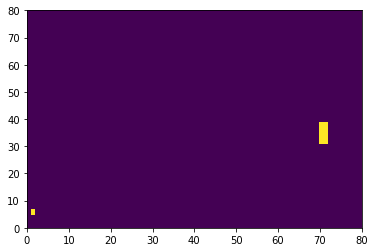

In [76]:
# pixels[:,70:72]  ## all potential right paddle locations
# pixels[:,10:70]  ## all potential ball locations
# pixels[20:25,8:10] = 10
plt.pcolor(pixels);

# Newsvendor with quick printing----------------------------------------------------------------- 

In [77]:
df = pd.read_csv('demand230.csv').drop(columns = 'Unnamed: 0').rename(columns = {'data_point':'day'})

In [78]:
cost = 2.25
qcost = 3.10
price = 3.75

In [79]:
# decision variables are (q, h1, h2, ..., h100)
obj = np.ones(101)/100
obj[0] = 0
lb = np.array([-np.inf]*101)
lb[0]=0
rhs = np.zeros(200)
direction = np.array(['<']*200)
A = np.zeros((200, 101))

In [80]:
for day in range(100):
    
    A[2*day,[0,day+1]] = [cost-qcost,1] # hi <= p*Di - q*c - g*(Di-q)  ----> (c-g)q + h <= (p-g)D
    rhs[2*day] = (price-qcost)*df.demand[day]
    
    A[2*day+1,[0,day+1]] = [cost,1]     # hi <= p*Di - q*c             ----> (c)q + h <= (p)D
    rhs[2*day+1] = price*df.demand[day]

In [81]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) 
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) 
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) 
spMod.Params.OutputFlag = 0 
spMod.optimize()

In [82]:
spMod_x.x[0]

1381.0

In [83]:
## Let's double check!!

qs = np.arange(1300,1450)
nq = len(qs)
outvec = np.zeros(nq)
for qi in range(nq):
    rev = price*df.demand
    excess = np.maximum(df.demand - qs[qi],0)
    cost2 = qs[qi]*cost + excess*qcost
    outvec[qi] = np.mean(rev-cost2)

qs[np.argmax(outvec)]

1381

# Fishing Problem---------------------------------------------------------------------------------------

In [84]:
delta = 0.8 # discount rate
T = 3 # time till lease expires

In [85]:
sValues=10*(2**np.arange(T+1)) # all possible tons of fish
tValues = np.arange(T+1) # all possible times

sN=len(sValues) # count of possible values
tN=len(tValues)

In [86]:
V = np.zeros((sN,tN)) # value function
U = np.zeros((sN,tN)) # place to store optimal decision

In [87]:
# Boundary conditions
V[:,tN-1] = 0 # we already have this since V was initialized with zeros...but in other problems this won't be 0...

In [88]:
for ti in reversed(range(tN-1)): # loop backwards in time
    for si in range(ti+1): # at time ti there are only ti+1 possible value of s!!! remember...we index on 0
        t = tValues[ti] # grab the actual values of s and t
        s = sValues[si]

        # value function if we choose not to fish or fish
        possible_values = [delta * V[si+1, ti+1],0.7*s + delta * V[si, ti+1]]
        V[si, ti] = np.max(possible_values) # optimal value function
        U[si, ti] = np.argmax(possible_values) # optimal choice...1 is don't fish, 2 is fish

In [89]:
print(V)

[[20.16 12.6   7.    0.  ]
 [ 0.   25.2  14.    0.  ]
 [ 0.    0.   28.    0.  ]
 [ 0.    0.    0.    0.  ]]


In [90]:
print(U)

[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
